### Phase 4: Build XGboost machine learning model for traffic flow forecast

In [1]:
# measure execution time
%load_ext autotime

time: 0 ns (started: 2023-06-30 18:12:44 +03:00)


In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

time: 0 ns (started: 2023-06-30 18:12:44 +03:00)


In [3]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

time: 2.77 s (started: 2023-06-30 18:12:44 +03:00)


### Load the dataset
Measure the traffic flow every 15 minutes for each path.

In [4]:
# read dataset
time_series = pd.read_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/time_series.txt',nrows=6)

# drop unecessary columns
#time_series.drop(["Traj ID","Taxi ID"],axis=1,inplace=True)

# print first two rows
time_series.shape

(6, 340)

time: 31 ms (started: 2023-06-30 18:12:51 +03:00)


In [5]:
time_series.head(3)

,Taxi ID,Traj ID,Path,Length,"(Timestamp('2008-05-18 00:00:00'), Timestamp('2008-05-18 00:30:00'))","(Timestamp('2008-05-18 00:30:00'), Timestamp('2008-05-18 01:00:00'))","(Timestamp('2008-05-18 01:00:00'), Timestamp('2008-05-18 01:30:00'))","(Timestamp('2008-05-18 01:30:00'), Timestamp('2008-05-18 02:00:00'))","(Timestamp('2008-05-18 02:00:00'), Timestamp('2008-05-18 02:30:00'))","(Timestamp('2008-05-18 02:30:00'), Timestamp('2008-05-18 03:00:00'))",...,"(Timestamp('2008-05-24 19:00:00'), Timestamp('2008-05-24 19:30:00'))","(Timestamp('2008-05-24 19:30:00'), Timestamp('2008-05-24 20:00:00'))","(Timestamp('2008-05-24 20:00:00'), Timestamp('2008-05-24 20:30:00'))","(Timestamp('2008-05-24 20:30:00'), Timestamp('2008-05-24 21:00:00'))","(Timestamp('2008-05-24 21:00:00'), Timestamp('2008-05-24 21:30:00'))","(Timestamp('2008-05-24 21:30:00'), Timestamp('2008-05-24 22:00:00'))","(Timestamp('2008-05-24 22:00:00'), Timestamp('2008-05-24 22:30:00'))","(Timestamp('2008-05-24 22:30:00'), Timestamp('2008-05-24 23:00:00'))","(Timestamp('2008-05-24 23:00:00'), Timestamp('2008-05-24 23:30:00'))","(Timestamp('2008-05-24 23:30:00'), Timestamp('2008-05-25 00:00:00'))"
0,293,151,"[60678630, 60678630]",2,0,3,1,0,1,0,...,1,0,2,0,0,1,1,0,2,1
1,114,115,"[776651709, 776651709]",2,4,9,7,7,5,16,...,3,12,1,4,5,6,0,4,4,4
2,58,127,"[680243315, 680243315, 397146706, 397146706, 3...",5,2,3,3,4,3,2,...,1,4,4,2,4,2,3,1,1,0


time: 32 ms (started: 2023-06-30 18:12:51 +03:00)


In [6]:
# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))
    
    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break
    
    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

# print first two rows
time_series.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-18 00:00:00,2008-05-18 00:30:00,2008-05-18 01:00:00,2008-05-18 01:30:00,2008-05-18 02:00:00,2008-05-18 02:30:00,...,2008-05-24 19:00:00,2008-05-24 19:30:00,2008-05-24 20:00:00,2008-05-24 20:30:00,2008-05-24 21:00:00,2008-05-24 21:30:00,2008-05-24 22:00:00,2008-05-24 22:30:00,2008-05-24 23:00:00,2008-05-24 23:30:00
0,293,151,"[60678630, 60678630]",2,0,3,1,0,1,0,...,1,0,2,0,0,1,1,0,2,1
1,114,115,"[776651709, 776651709]",2,4,9,7,7,5,16,...,3,12,1,4,5,6,0,4,4,4


time: 62 ms (started: 2023-06-30 18:12:51 +03:00)


### Transform the dataset
Use melt function to convert time columns as rows and the rest of them as columns.

In [7]:
# reshape the data from column format to row format
id_cols = ['Taxi ID','Traj ID','Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

# print first rows of the dataset
time_series.shape

(2016, 6)

time: 31 ms (started: 2023-06-30 18:12:52 +03:00)


In [8]:
time_series.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
4,212,224,"[287958607, 254466695, 254466695, 397269730, 3...",11,2008-05-18 00:00:00,4
10,212,224,"[287958607, 254466695, 254466695, 397269730, 3...",11,2008-05-18 00:30:00,0
16,212,224,"[287958607, 254466695, 254466695, 397269730, 3...",11,2008-05-18 01:00:00,1
22,212,224,"[287958607, 254466695, 254466695, 397269730, 3...",11,2008-05-18 01:30:00,4
28,212,224,"[287958607, 254466695, 254466695, 397269730, 3...",11,2008-05-18 02:00:00,0


time: 16 ms (started: 2023-06-30 18:12:53 +03:00)


Encode the path names to numerical ones for forecast

In [9]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

time: 453 ms (started: 2023-06-30 18:12:55 +03:00)


In [10]:
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
4,212,224,0,11,2008-05-18 00:00:00,4
10,212,224,0,11,2008-05-18 00:30:00,0
16,212,224,0,11,2008-05-18 01:00:00,1
22,212,224,0,11,2008-05-18 01:30:00,4
28,212,224,0,11,2008-05-18 02:00:00,0


time: 16 ms (started: 2023-06-30 18:12:55 +03:00)


### Convert the time series dataset to a supervised problem
Use for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [11]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

data = pd.DataFrame()

# do the following for each path in the dataset
for item in time_series['Path'].unique():
    # call function only for traffic flow columns
    x = series_to_supervised(time_series[time_series['Path'] == item].drop(['Length','Time Column','Path','Traj ID','Taxi ID'],axis=1), 4,1)
    
    # the rest of the columns are concatenated as they were
    x['Path'] = item
    x['Length'] = time_series[time_series['Path'] == item]['Length']
    x['Taxi ID'] = time_series[time_series['Path'] == item]['Taxi ID']
    x['Traj ID'] = time_series[time_series['Path'] == item]['Traj ID']
    data = pd.concat([data,x])

data['Time Column'] = time_series['Time Column']
time_series = data

time: 78 ms (started: 2023-06-30 18:12:56 +03:00)


In [12]:
time_series.set_index(pd.to_datetime(time_series['Time Column']),inplace=True)
time_series.sort_index(inplace=True)

time: 15 ms (started: 2023-06-30 18:13:01 +03:00)


### Feature Creation From Time Information
We define some features based on time series timestamps.
- Day, dayfweek, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.

In [13]:
# extract timestamp information to different columns
time_series['hour'] = time_series['Time Column'].dt.hour
time_series['dayofweek'] = time_series['Time Column'].dt.dayofweek
time_series['day'] = time_series['Time Column'].dt.day
time_series['minute'] = time_series['Time Column'].dt.minute

time: 16 ms (started: 2023-06-30 18:13:03 +03:00)


In [14]:
# circular Encoding for cyclic time features
time_series['hour_sin'] = np.sin(2 * np.pi * time_series['hour'] / 24)
time_series['hour_cos'] = np.cos(2 * np.pi * time_series['hour'] / 24)

time: 0 ns (started: 2023-06-30 18:13:03 +03:00)


### Extract features about trend of time series
- Rolling mean and rolling standard deviation are statistical measures that are commonly used in time series analysis and data smoothing. They are calculated over a sliding window or a rolling window, where the window size determines the number of consecutive data points included in the calculation.

</br>

- Rolling Mean: The rolling mean (or moving average) calculates the average value of a time series within a specific window. It smooths out short-term fluctuations and provides a smoothed representation of the data. The rolling mean at each time point is the average of the values within the window centered around that time point.

</br>

- Rolling Standard Deviation: The rolling standard deviation calculates the standard deviation of a time series within a specific window. It measures the dispersion or variability of the data points within the window. The rolling standard deviation at each time point is the standard deviation of the values within the window centered around that time point.

In [15]:
time_series['rolling_mean'] = 0
time_series['rolling_mean'] = time_series.iloc[:,0:4].mean(axis=1)

time: 0 ns (started: 2023-06-30 18:13:10 +03:00)


### Train - Test split
Split the data into two datasets train and test.
The time inteval of all observations in this dataset are within [18-05-2008, 24-05-2008]
- Train dataset contains all the data for each path till 2008-05-23 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [16]:
# define train data
train = time_series.loc[time_series.index < '2008-05-23']
train = train.sort_index()

# define test data
test = time_series.loc[time_series.index >= '2008-05-23']
test = test.sort_index()

print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (1416, 17)
Test set shape:  (576, 17)
time: 0 ns (started: 2023-06-30 18:13:11 +03:00)


### Define Features and Labels
- Features will help the XGboost algorithm to predict the putput value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

In [18]:
# define features
features = time_series.drop(['Time Column','Traffic Flow 1(t)'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

time: 16 ms (started: 2023-06-30 18:13:20 +03:00)


In [19]:
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (1416, 15)
Shape of y_train is:  (1416, 1)
Shape of X_test is:  (576, 15)
Shape of y_test is:  (576, 1)
time: 0 ns (started: 2023-06-30 18:13:21 +03:00)


### Train an XGboost model
We will fit all the data in this model!

In [20]:
import xgboost as xgb

time: 125 ms (started: 2023-06-30 18:13:21 +03:00)


In [30]:
# define XGBoost regressor
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=5000,
    early_stopping_rounds = 10,
    max_depth = 4,
    learning_rate=0.001,
    gamma=2,
    alpha = 2
)

# train the XGBoost model with feature weights, use validation set on test data)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test,y_test)], 
        verbose=True)

[0]	validation_0-rmse:3.56766	validation_1-rmse:3.48578
[1]	validation_0-rmse:3.56540	validation_1-rmse:3.48348
[2]	validation_0-rmse:3.56314	validation_1-rmse:3.48119
[3]	validation_0-rmse:3.56089	validation_1-rmse:3.47891
[4]	validation_0-rmse:3.55863	validation_1-rmse:3.47662
[5]	validation_0-rmse:3.55639	validation_1-rmse:3.47434
[6]	validation_0-rmse:3.55414	validation_1-rmse:3.47206
[7]	validation_0-rmse:3.55190	validation_1-rmse:3.46979
[8]	validation_0-rmse:3.54966	validation_1-rmse:3.46752
[9]	validation_0-rmse:3.54742	validation_1-rmse:3.46525
[10]	validation_0-rmse:3.54519	validation_1-rmse:3.46298
[11]	validation_0-rmse:3.54296	validation_1-rmse:3.46072
[12]	validation_0-rmse:3.54073	validation_1-rmse:3.45846
[13]	validation_0-rmse:3.53851	validation_1-rmse:3.45621
[14]	validation_0-rmse:3.53628	validation_1-rmse:3.45395
[15]	validation_0-rmse:3.53407	validation_1-rmse:3.45170
[16]	validation_0-rmse:3.53185	validation_1-rmse:3.44946
[17]	validation_0-rmse:3.52964	validation

[143]	validation_0-rmse:3.27328	validation_1-rmse:3.19115
[144]	validation_0-rmse:3.27142	validation_1-rmse:3.18925
[145]	validation_0-rmse:3.26956	validation_1-rmse:3.18746
[146]	validation_0-rmse:3.26770	validation_1-rmse:3.18560
[147]	validation_0-rmse:3.26584	validation_1-rmse:3.18382
[148]	validation_0-rmse:3.26398	validation_1-rmse:3.18195
[149]	validation_0-rmse:3.26213	validation_1-rmse:3.18013
[150]	validation_0-rmse:3.26028	validation_1-rmse:3.17833
[151]	validation_0-rmse:3.25842	validation_1-rmse:3.17650
[152]	validation_0-rmse:3.25658	validation_1-rmse:3.17464
[153]	validation_0-rmse:3.25473	validation_1-rmse:3.17283
[154]	validation_0-rmse:3.25289	validation_1-rmse:3.17103
[155]	validation_0-rmse:3.25106	validation_1-rmse:3.16920
[156]	validation_0-rmse:3.24922	validation_1-rmse:3.16735
[157]	validation_0-rmse:3.24739	validation_1-rmse:3.16560
[158]	validation_0-rmse:3.24555	validation_1-rmse:3.16380
[159]	validation_0-rmse:3.24372	validation_1-rmse:3.16202
[160]	validati

[285]	validation_0-rmse:3.03253	validation_1-rmse:2.95313
[286]	validation_0-rmse:3.03100	validation_1-rmse:2.95167
[287]	validation_0-rmse:3.02947	validation_1-rmse:2.95013
[288]	validation_0-rmse:3.02794	validation_1-rmse:2.94856
[289]	validation_0-rmse:3.02642	validation_1-rmse:2.94710
[290]	validation_0-rmse:3.02489	validation_1-rmse:2.94561
[291]	validation_0-rmse:3.02337	validation_1-rmse:2.94407
[292]	validation_0-rmse:3.02185	validation_1-rmse:2.94257
[293]	validation_0-rmse:3.02034	validation_1-rmse:2.94103
[294]	validation_0-rmse:3.01883	validation_1-rmse:2.93960
[295]	validation_0-rmse:3.01732	validation_1-rmse:2.93806
[296]	validation_0-rmse:3.01580	validation_1-rmse:2.93663
[297]	validation_0-rmse:3.01430	validation_1-rmse:2.93510
[298]	validation_0-rmse:3.01279	validation_1-rmse:2.93359
[299]	validation_0-rmse:3.01129	validation_1-rmse:2.93215
[300]	validation_0-rmse:3.00979	validation_1-rmse:2.93066
[301]	validation_0-rmse:3.00829	validation_1-rmse:2.92915
[302]	validati

[427]	validation_0-rmse:2.83508	validation_1-rmse:2.75648
[428]	validation_0-rmse:2.83383	validation_1-rmse:2.75520
[429]	validation_0-rmse:2.83258	validation_1-rmse:2.75394
[430]	validation_0-rmse:2.83132	validation_1-rmse:2.75271
[431]	validation_0-rmse:2.83008	validation_1-rmse:2.75143
[432]	validation_0-rmse:2.82882	validation_1-rmse:2.75021
[433]	validation_0-rmse:2.82758	validation_1-rmse:2.74899
[434]	validation_0-rmse:2.82634	validation_1-rmse:2.74774
[435]	validation_0-rmse:2.82509	validation_1-rmse:2.74648
[436]	validation_0-rmse:2.82386	validation_1-rmse:2.74524
[437]	validation_0-rmse:2.82262	validation_1-rmse:2.74403
[438]	validation_0-rmse:2.82139	validation_1-rmse:2.74276
[439]	validation_0-rmse:2.82015	validation_1-rmse:2.74155
[440]	validation_0-rmse:2.81891	validation_1-rmse:2.74032
[441]	validation_0-rmse:2.81768	validation_1-rmse:2.73911
[442]	validation_0-rmse:2.81645	validation_1-rmse:2.73786
[443]	validation_0-rmse:2.81522	validation_1-rmse:2.73665
[444]	validati

[569]	validation_0-rmse:2.67358	validation_1-rmse:2.59537
[570]	validation_0-rmse:2.67254	validation_1-rmse:2.59434
[571]	validation_0-rmse:2.67151	validation_1-rmse:2.59335
[572]	validation_0-rmse:2.67048	validation_1-rmse:2.59234
[573]	validation_0-rmse:2.66945	validation_1-rmse:2.59132
[574]	validation_0-rmse:2.66843	validation_1-rmse:2.59038
[575]	validation_0-rmse:2.66740	validation_1-rmse:2.58937
[576]	validation_0-rmse:2.66638	validation_1-rmse:2.58837
[577]	validation_0-rmse:2.66536	validation_1-rmse:2.58740
[578]	validation_0-rmse:2.66434	validation_1-rmse:2.58639
[579]	validation_0-rmse:2.66331	validation_1-rmse:2.58537
[580]	validation_0-rmse:2.66229	validation_1-rmse:2.58432
[581]	validation_0-rmse:2.66127	validation_1-rmse:2.58331
[582]	validation_0-rmse:2.66024	validation_1-rmse:2.58227
[583]	validation_0-rmse:2.65925	validation_1-rmse:2.58140
[584]	validation_0-rmse:2.65823	validation_1-rmse:2.58040
[585]	validation_0-rmse:2.65722	validation_1-rmse:2.57941
[586]	validati

[711]	validation_0-rmse:2.54059	validation_1-rmse:2.46826
[712]	validation_0-rmse:2.53972	validation_1-rmse:2.46750
[713]	validation_0-rmse:2.53888	validation_1-rmse:2.46675
[714]	validation_0-rmse:2.53804	validation_1-rmse:2.46593
[715]	validation_0-rmse:2.53718	validation_1-rmse:2.46517
[716]	validation_0-rmse:2.53632	validation_1-rmse:2.46442
[717]	validation_0-rmse:2.53546	validation_1-rmse:2.46361
[718]	validation_0-rmse:2.53462	validation_1-rmse:2.46287
[719]	validation_0-rmse:2.53377	validation_1-rmse:2.46208
[720]	validation_0-rmse:2.53293	validation_1-rmse:2.46126
[721]	validation_0-rmse:2.53210	validation_1-rmse:2.46053
[722]	validation_0-rmse:2.53125	validation_1-rmse:2.45977
[723]	validation_0-rmse:2.53042	validation_1-rmse:2.45897
[724]	validation_0-rmse:2.52959	validation_1-rmse:2.45823
[725]	validation_0-rmse:2.52874	validation_1-rmse:2.45749
[726]	validation_0-rmse:2.52789	validation_1-rmse:2.45669
[727]	validation_0-rmse:2.52704	validation_1-rmse:2.45595
[728]	validati

[853]	validation_0-rmse:2.43091	validation_1-rmse:2.36772
[854]	validation_0-rmse:2.43019	validation_1-rmse:2.36709
[855]	validation_0-rmse:2.42948	validation_1-rmse:2.36645
[856]	validation_0-rmse:2.42880	validation_1-rmse:2.36579
[857]	validation_0-rmse:2.42810	validation_1-rmse:2.36516
[858]	validation_0-rmse:2.42741	validation_1-rmse:2.36450
[859]	validation_0-rmse:2.42670	validation_1-rmse:2.36388
[860]	validation_0-rmse:2.42600	validation_1-rmse:2.36322
[861]	validation_0-rmse:2.42530	validation_1-rmse:2.36259
[862]	validation_0-rmse:2.42462	validation_1-rmse:2.36193
[863]	validation_0-rmse:2.42391	validation_1-rmse:2.36130
[864]	validation_0-rmse:2.42322	validation_1-rmse:2.36065
[865]	validation_0-rmse:2.42254	validation_1-rmse:2.36001
[866]	validation_0-rmse:2.42187	validation_1-rmse:2.35936
[867]	validation_0-rmse:2.42116	validation_1-rmse:2.35875
[868]	validation_0-rmse:2.42048	validation_1-rmse:2.35810
[869]	validation_0-rmse:2.41978	validation_1-rmse:2.35749
[870]	validati

[995]	validation_0-rmse:2.34053	validation_1-rmse:2.28374
[996]	validation_0-rmse:2.33994	validation_1-rmse:2.28317
[997]	validation_0-rmse:2.33937	validation_1-rmse:2.28266
[998]	validation_0-rmse:2.33879	validation_1-rmse:2.28209
[999]	validation_0-rmse:2.33821	validation_1-rmse:2.28160
[1000]	validation_0-rmse:2.33766	validation_1-rmse:2.28109
[1001]	validation_0-rmse:2.33709	validation_1-rmse:2.28052
[1002]	validation_0-rmse:2.33652	validation_1-rmse:2.28002
[1003]	validation_0-rmse:2.33595	validation_1-rmse:2.27945
[1004]	validation_0-rmse:2.33537	validation_1-rmse:2.27894
[1005]	validation_0-rmse:2.33480	validation_1-rmse:2.27838
[1006]	validation_0-rmse:2.33423	validation_1-rmse:2.27789
[1007]	validation_0-rmse:2.33366	validation_1-rmse:2.27729
[1008]	validation_0-rmse:2.33310	validation_1-rmse:2.27678
[1009]	validation_0-rmse:2.33253	validation_1-rmse:2.27622
[1010]	validation_0-rmse:2.33198	validation_1-rmse:2.27572
[1011]	validation_0-rmse:2.33142	validation_1-rmse:2.27523
[1

[1134]	validation_0-rmse:2.26787	validation_1-rmse:2.21819
[1135]	validation_0-rmse:2.26739	validation_1-rmse:2.21779
[1136]	validation_0-rmse:2.26691	validation_1-rmse:2.21738
[1137]	validation_0-rmse:2.26645	validation_1-rmse:2.21697
[1138]	validation_0-rmse:2.26597	validation_1-rmse:2.21656
[1139]	validation_0-rmse:2.26551	validation_1-rmse:2.21616
[1140]	validation_0-rmse:2.26503	validation_1-rmse:2.21575
[1141]	validation_0-rmse:2.26455	validation_1-rmse:2.21536
[1142]	validation_0-rmse:2.26408	validation_1-rmse:2.21494
[1143]	validation_0-rmse:2.26361	validation_1-rmse:2.21455
[1144]	validation_0-rmse:2.26315	validation_1-rmse:2.21415
[1145]	validation_0-rmse:2.26267	validation_1-rmse:2.21375
[1146]	validation_0-rmse:2.26222	validation_1-rmse:2.21335
[1147]	validation_0-rmse:2.26175	validation_1-rmse:2.21292
[1148]	validation_0-rmse:2.26128	validation_1-rmse:2.21252
[1149]	validation_0-rmse:2.26081	validation_1-rmse:2.21212
[1150]	validation_0-rmse:2.26036	validation_1-rmse:2.211

[1273]	validation_0-rmse:2.20779	validation_1-rmse:2.16428
[1274]	validation_0-rmse:2.20740	validation_1-rmse:2.16393
[1275]	validation_0-rmse:2.20699	validation_1-rmse:2.16358
[1276]	validation_0-rmse:2.20661	validation_1-rmse:2.16323
[1277]	validation_0-rmse:2.20624	validation_1-rmse:2.16289
[1278]	validation_0-rmse:2.20583	validation_1-rmse:2.16252
[1279]	validation_0-rmse:2.20543	validation_1-rmse:2.16215
[1280]	validation_0-rmse:2.20505	validation_1-rmse:2.16181
[1281]	validation_0-rmse:2.20467	validation_1-rmse:2.16146
[1282]	validation_0-rmse:2.20428	validation_1-rmse:2.16112
[1283]	validation_0-rmse:2.20387	validation_1-rmse:2.16075
[1284]	validation_0-rmse:2.20350	validation_1-rmse:2.16041
[1285]	validation_0-rmse:2.20311	validation_1-rmse:2.16004
[1286]	validation_0-rmse:2.20273	validation_1-rmse:2.15975
[1287]	validation_0-rmse:2.20236	validation_1-rmse:2.15942
[1288]	validation_0-rmse:2.20197	validation_1-rmse:2.15906
[1289]	validation_0-rmse:2.20158	validation_1-rmse:2.158

[1412]	validation_0-rmse:2.15911	validation_1-rmse:2.12115
[1413]	validation_0-rmse:2.15880	validation_1-rmse:2.12089
[1414]	validation_0-rmse:2.15849	validation_1-rmse:2.12061
[1415]	validation_0-rmse:2.15818	validation_1-rmse:2.12032
[1416]	validation_0-rmse:2.15787	validation_1-rmse:2.12006
[1417]	validation_0-rmse:2.15756	validation_1-rmse:2.11978
[1418]	validation_0-rmse:2.15725	validation_1-rmse:2.11950
[1419]	validation_0-rmse:2.15694	validation_1-rmse:2.11924
[1420]	validation_0-rmse:2.15664	validation_1-rmse:2.11904
[1421]	validation_0-rmse:2.15633	validation_1-rmse:2.11876
[1422]	validation_0-rmse:2.15602	validation_1-rmse:2.11847
[1423]	validation_0-rmse:2.15572	validation_1-rmse:2.11819
[1424]	validation_0-rmse:2.15541	validation_1-rmse:2.11791
[1425]	validation_0-rmse:2.15509	validation_1-rmse:2.11764
[1426]	validation_0-rmse:2.15480	validation_1-rmse:2.11737
[1427]	validation_0-rmse:2.15449	validation_1-rmse:2.11711
[1428]	validation_0-rmse:2.15418	validation_1-rmse:2.116

[1550]	validation_0-rmse:2.11989	validation_1-rmse:2.08841
[1551]	validation_0-rmse:2.11962	validation_1-rmse:2.08822
[1552]	validation_0-rmse:2.11936	validation_1-rmse:2.08800
[1553]	validation_0-rmse:2.11910	validation_1-rmse:2.08778
[1554]	validation_0-rmse:2.11885	validation_1-rmse:2.08760
[1555]	validation_0-rmse:2.11860	validation_1-rmse:2.08738
[1556]	validation_0-rmse:2.11834	validation_1-rmse:2.08715
[1557]	validation_0-rmse:2.11808	validation_1-rmse:2.08695
[1558]	validation_0-rmse:2.11782	validation_1-rmse:2.08672
[1559]	validation_0-rmse:2.11757	validation_1-rmse:2.08653
[1560]	validation_0-rmse:2.11732	validation_1-rmse:2.08632
[1561]	validation_0-rmse:2.11707	validation_1-rmse:2.08615
[1562]	validation_0-rmse:2.11681	validation_1-rmse:2.08597
[1563]	validation_0-rmse:2.11657	validation_1-rmse:2.08575
[1564]	validation_0-rmse:2.11632	validation_1-rmse:2.08553
[1565]	validation_0-rmse:2.11607	validation_1-rmse:2.08533
[1566]	validation_0-rmse:2.11581	validation_1-rmse:2.085

[1688]	validation_0-rmse:2.08718	validation_1-rmse:2.06362
[1689]	validation_0-rmse:2.08697	validation_1-rmse:2.06351
[1690]	validation_0-rmse:2.08675	validation_1-rmse:2.06336
[1691]	validation_0-rmse:2.08652	validation_1-rmse:2.06324
[1692]	validation_0-rmse:2.08630	validation_1-rmse:2.06312
[1693]	validation_0-rmse:2.08609	validation_1-rmse:2.06296
[1694]	validation_0-rmse:2.08587	validation_1-rmse:2.06284
[1695]	validation_0-rmse:2.08565	validation_1-rmse:2.06270
[1696]	validation_0-rmse:2.08543	validation_1-rmse:2.06255
[1697]	validation_0-rmse:2.08522	validation_1-rmse:2.06238
[1698]	validation_0-rmse:2.08498	validation_1-rmse:2.06223
[1699]	validation_0-rmse:2.08477	validation_1-rmse:2.06208
[1700]	validation_0-rmse:2.08455	validation_1-rmse:2.06195
[1701]	validation_0-rmse:2.08433	validation_1-rmse:2.06183
[1702]	validation_0-rmse:2.08413	validation_1-rmse:2.06167
[1703]	validation_0-rmse:2.08390	validation_1-rmse:2.06154
[1704]	validation_0-rmse:2.08368	validation_1-rmse:2.061

[1827]	validation_0-rmse:2.05906	validation_1-rmse:2.04599
[1828]	validation_0-rmse:2.05888	validation_1-rmse:2.04588
[1829]	validation_0-rmse:2.05869	validation_1-rmse:2.04577
[1830]	validation_0-rmse:2.05851	validation_1-rmse:2.04568
[1831]	validation_0-rmse:2.05833	validation_1-rmse:2.04555
[1832]	validation_0-rmse:2.05814	validation_1-rmse:2.04544
[1833]	validation_0-rmse:2.05796	validation_1-rmse:2.04533
[1834]	validation_0-rmse:2.05778	validation_1-rmse:2.04523
[1835]	validation_0-rmse:2.05761	validation_1-rmse:2.04512
[1836]	validation_0-rmse:2.05742	validation_1-rmse:2.04501
[1837]	validation_0-rmse:2.05723	validation_1-rmse:2.04490
[1838]	validation_0-rmse:2.05706	validation_1-rmse:2.04480
[1839]	validation_0-rmse:2.05688	validation_1-rmse:2.04469
[1840]	validation_0-rmse:2.05670	validation_1-rmse:2.04457
[1841]	validation_0-rmse:2.05651	validation_1-rmse:2.04446
[1842]	validation_0-rmse:2.05631	validation_1-rmse:2.04434
[1843]	validation_0-rmse:2.05613	validation_1-rmse:2.044

[1965]	validation_0-rmse:2.03563	validation_1-rmse:2.03148
[1966]	validation_0-rmse:2.03548	validation_1-rmse:2.03139
[1967]	validation_0-rmse:2.03532	validation_1-rmse:2.03129
[1968]	validation_0-rmse:2.03515	validation_1-rmse:2.03119
[1969]	validation_0-rmse:2.03500	validation_1-rmse:2.03112
[1970]	validation_0-rmse:2.03484	validation_1-rmse:2.03100
[1971]	validation_0-rmse:2.03468	validation_1-rmse:2.03093
[1972]	validation_0-rmse:2.03451	validation_1-rmse:2.03083
[1973]	validation_0-rmse:2.03436	validation_1-rmse:2.03078
[1974]	validation_0-rmse:2.03419	validation_1-rmse:2.03066
[1975]	validation_0-rmse:2.03403	validation_1-rmse:2.03056
[1976]	validation_0-rmse:2.03387	validation_1-rmse:2.03051
[1977]	validation_0-rmse:2.03371	validation_1-rmse:2.03039
[1978]	validation_0-rmse:2.03356	validation_1-rmse:2.03033
[1979]	validation_0-rmse:2.03339	validation_1-rmse:2.03024
[1980]	validation_0-rmse:2.03324	validation_1-rmse:2.03017
[1981]	validation_0-rmse:2.03308	validation_1-rmse:2.030

[2104]	validation_0-rmse:2.01489	validation_1-rmse:2.02055
[2105]	validation_0-rmse:2.01476	validation_1-rmse:2.02048
[2106]	validation_0-rmse:2.01460	validation_1-rmse:2.02039
[2107]	validation_0-rmse:2.01447	validation_1-rmse:2.02032
[2108]	validation_0-rmse:2.01434	validation_1-rmse:2.02023
[2109]	validation_0-rmse:2.01422	validation_1-rmse:2.02017
[2110]	validation_0-rmse:2.01407	validation_1-rmse:2.02010
[2111]	validation_0-rmse:2.01394	validation_1-rmse:2.02002
[2112]	validation_0-rmse:2.01378	validation_1-rmse:2.01995
[2113]	validation_0-rmse:2.01366	validation_1-rmse:2.01986
[2114]	validation_0-rmse:2.01353	validation_1-rmse:2.01980
[2115]	validation_0-rmse:2.01340	validation_1-rmse:2.01973
[2116]	validation_0-rmse:2.01325	validation_1-rmse:2.01965
[2117]	validation_0-rmse:2.01313	validation_1-rmse:2.01958
[2118]	validation_0-rmse:2.01300	validation_1-rmse:2.01949
[2119]	validation_0-rmse:2.01287	validation_1-rmse:2.01943
[2120]	validation_0-rmse:2.01272	validation_1-rmse:2.019

[2243]	validation_0-rmse:1.99647	validation_1-rmse:2.01149
[2244]	validation_0-rmse:1.99633	validation_1-rmse:2.01141
[2245]	validation_0-rmse:1.99620	validation_1-rmse:2.01136
[2246]	validation_0-rmse:1.99608	validation_1-rmse:2.01131
[2247]	validation_0-rmse:1.99594	validation_1-rmse:2.01123
[2248]	validation_0-rmse:1.99580	validation_1-rmse:2.01119
[2249]	validation_0-rmse:1.99567	validation_1-rmse:2.01112
[2250]	validation_0-rmse:1.99553	validation_1-rmse:2.01106
[2251]	validation_0-rmse:1.99542	validation_1-rmse:2.01100
[2252]	validation_0-rmse:1.99529	validation_1-rmse:2.01096
[2253]	validation_0-rmse:1.99515	validation_1-rmse:2.01089
[2254]	validation_0-rmse:1.99504	validation_1-rmse:2.01083
[2255]	validation_0-rmse:1.99491	validation_1-rmse:2.01078
[2256]	validation_0-rmse:1.99477	validation_1-rmse:2.01071
[2257]	validation_0-rmse:1.99464	validation_1-rmse:2.01066
[2258]	validation_0-rmse:1.99453	validation_1-rmse:2.01061
[2259]	validation_0-rmse:1.99442	validation_1-rmse:2.010

[2382]	validation_0-rmse:1.97987	validation_1-rmse:2.00408
[2383]	validation_0-rmse:1.97976	validation_1-rmse:2.00403
[2384]	validation_0-rmse:1.97965	validation_1-rmse:2.00394
[2385]	validation_0-rmse:1.97953	validation_1-rmse:2.00390
[2386]	validation_0-rmse:1.97942	validation_1-rmse:2.00382
[2387]	validation_0-rmse:1.97930	validation_1-rmse:2.00377
[2388]	validation_0-rmse:1.97919	validation_1-rmse:2.00369
[2389]	validation_0-rmse:1.97908	validation_1-rmse:2.00362
[2390]	validation_0-rmse:1.97897	validation_1-rmse:2.00357
[2391]	validation_0-rmse:1.97885	validation_1-rmse:2.00350
[2392]	validation_0-rmse:1.97873	validation_1-rmse:2.00345
[2393]	validation_0-rmse:1.97862	validation_1-rmse:2.00338
[2394]	validation_0-rmse:1.97852	validation_1-rmse:2.00330
[2395]	validation_0-rmse:1.97840	validation_1-rmse:2.00325
[2396]	validation_0-rmse:1.97829	validation_1-rmse:2.00318
[2397]	validation_0-rmse:1.97818	validation_1-rmse:2.00313
[2398]	validation_0-rmse:1.97807	validation_1-rmse:2.003

[2521]	validation_0-rmse:1.96505	validation_1-rmse:1.99599
[2522]	validation_0-rmse:1.96494	validation_1-rmse:1.99593
[2523]	validation_0-rmse:1.96485	validation_1-rmse:1.99588
[2524]	validation_0-rmse:1.96475	validation_1-rmse:1.99582
[2525]	validation_0-rmse:1.96464	validation_1-rmse:1.99577
[2526]	validation_0-rmse:1.96455	validation_1-rmse:1.99571
[2527]	validation_0-rmse:1.96446	validation_1-rmse:1.99567
[2528]	validation_0-rmse:1.96436	validation_1-rmse:1.99562
[2529]	validation_0-rmse:1.96427	validation_1-rmse:1.99555
[2530]	validation_0-rmse:1.96416	validation_1-rmse:1.99551
[2531]	validation_0-rmse:1.96407	validation_1-rmse:1.99546
[2532]	validation_0-rmse:1.96398	validation_1-rmse:1.99539
[2533]	validation_0-rmse:1.96387	validation_1-rmse:1.99534
[2534]	validation_0-rmse:1.96378	validation_1-rmse:1.99528
[2535]	validation_0-rmse:1.96370	validation_1-rmse:1.99524
[2536]	validation_0-rmse:1.96359	validation_1-rmse:1.99519
[2537]	validation_0-rmse:1.96349	validation_1-rmse:1.995

[2659]	validation_0-rmse:1.95224	validation_1-rmse:1.98984
[2660]	validation_0-rmse:1.95216	validation_1-rmse:1.98980
[2661]	validation_0-rmse:1.95208	validation_1-rmse:1.98978
[2662]	validation_0-rmse:1.95199	validation_1-rmse:1.98975
[2663]	validation_0-rmse:1.95188	validation_1-rmse:1.98975
[2664]	validation_0-rmse:1.95180	validation_1-rmse:1.98971
[2665]	validation_0-rmse:1.95168	validation_1-rmse:1.98971
[2666]	validation_0-rmse:1.95156	validation_1-rmse:1.98970
[2667]	validation_0-rmse:1.95145	validation_1-rmse:1.98970
[2668]	validation_0-rmse:1.95133	validation_1-rmse:1.98969
[2669]	validation_0-rmse:1.95122	validation_1-rmse:1.98969
[2670]	validation_0-rmse:1.95110	validation_1-rmse:1.98968
[2671]	validation_0-rmse:1.95099	validation_1-rmse:1.98968
[2672]	validation_0-rmse:1.95088	validation_1-rmse:1.98967
[2673]	validation_0-rmse:1.95080	validation_1-rmse:1.98963
[2674]	validation_0-rmse:1.95068	validation_1-rmse:1.98963
[2675]	validation_0-rmse:1.95057	validation_1-rmse:1.989

[2798]	validation_0-rmse:1.93893	validation_1-rmse:1.98870
[2799]	validation_0-rmse:1.93884	validation_1-rmse:1.98870
[2800]	validation_0-rmse:1.93876	validation_1-rmse:1.98869
[2801]	validation_0-rmse:1.93868	validation_1-rmse:1.98867
[2802]	validation_0-rmse:1.93860	validation_1-rmse:1.98866
[2803]	validation_0-rmse:1.93850	validation_1-rmse:1.98867
[2804]	validation_0-rmse:1.93842	validation_1-rmse:1.98864
[2805]	validation_0-rmse:1.93833	validation_1-rmse:1.98862
[2806]	validation_0-rmse:1.93825	validation_1-rmse:1.98862
[2807]	validation_0-rmse:1.93817	validation_1-rmse:1.98860
[2808]	validation_0-rmse:1.93809	validation_1-rmse:1.98858
[2809]	validation_0-rmse:1.93801	validation_1-rmse:1.98856
[2810]	validation_0-rmse:1.93793	validation_1-rmse:1.98854
[2811]	validation_0-rmse:1.93785	validation_1-rmse:1.98852
[2812]	validation_0-rmse:1.93777	validation_1-rmse:1.98851
[2813]	validation_0-rmse:1.93769	validation_1-rmse:1.98849
[2814]	validation_0-rmse:1.93761	validation_1-rmse:1.988

[2937]	validation_0-rmse:1.92780	validation_1-rmse:1.98657
[2938]	validation_0-rmse:1.92771	validation_1-rmse:1.98657
[2939]	validation_0-rmse:1.92764	validation_1-rmse:1.98656
[2940]	validation_0-rmse:1.92755	validation_1-rmse:1.98656
[2941]	validation_0-rmse:1.92747	validation_1-rmse:1.98655
[2942]	validation_0-rmse:1.92738	validation_1-rmse:1.98655
[2943]	validation_0-rmse:1.92730	validation_1-rmse:1.98652
[2944]	validation_0-rmse:1.92723	validation_1-rmse:1.98651
[2945]	validation_0-rmse:1.92716	validation_1-rmse:1.98649
[2946]	validation_0-rmse:1.92709	validation_1-rmse:1.98648
[2947]	validation_0-rmse:1.92701	validation_1-rmse:1.98646
[2948]	validation_0-rmse:1.92692	validation_1-rmse:1.98647
[2949]	validation_0-rmse:1.92685	validation_1-rmse:1.98645
[2950]	validation_0-rmse:1.92677	validation_1-rmse:1.98642
[2951]	validation_0-rmse:1.92671	validation_1-rmse:1.98641
[2952]	validation_0-rmse:1.92664	validation_1-rmse:1.98640
[2953]	validation_0-rmse:1.92655	validation_1-rmse:1.986

[3076]	validation_0-rmse:1.91745	validation_1-rmse:1.98528
[3077]	validation_0-rmse:1.91738	validation_1-rmse:1.98530
[3078]	validation_0-rmse:1.91732	validation_1-rmse:1.98530
[3079]	validation_0-rmse:1.91724	validation_1-rmse:1.98529
[3080]	validation_0-rmse:1.91716	validation_1-rmse:1.98530
[3081]	validation_0-rmse:1.91710	validation_1-rmse:1.98528
[3082]	validation_0-rmse:1.91704	validation_1-rmse:1.98529
[3083]	validation_0-rmse:1.91697	validation_1-rmse:1.98527
[3084]	validation_0-rmse:1.91691	validation_1-rmse:1.98527
[3085]	validation_0-rmse:1.91682	validation_1-rmse:1.98528
[3086]	validation_0-rmse:1.91671	validation_1-rmse:1.98524
[3087]	validation_0-rmse:1.91664	validation_1-rmse:1.98522
[3088]	validation_0-rmse:1.91656	validation_1-rmse:1.98523
[3089]	validation_0-rmse:1.91644	validation_1-rmse:1.98518
[3090]	validation_0-rmse:1.91638	validation_1-rmse:1.98519
[3091]	validation_0-rmse:1.91626	validation_1-rmse:1.98514
[3092]	validation_0-rmse:1.91620	validation_1-rmse:1.985

[3215]	validation_0-rmse:1.90569	validation_1-rmse:1.98361
[3216]	validation_0-rmse:1.90558	validation_1-rmse:1.98356
[3217]	validation_0-rmse:1.90552	validation_1-rmse:1.98355
[3218]	validation_0-rmse:1.90545	validation_1-rmse:1.98354
[3219]	validation_0-rmse:1.90535	validation_1-rmse:1.98352
[3220]	validation_0-rmse:1.90529	validation_1-rmse:1.98353
[3221]	validation_0-rmse:1.90523	validation_1-rmse:1.98355
[3222]	validation_0-rmse:1.90513	validation_1-rmse:1.98352
[3223]	validation_0-rmse:1.90506	validation_1-rmse:1.98352
[3224]	validation_0-rmse:1.90501	validation_1-rmse:1.98353
[3225]	validation_0-rmse:1.90494	validation_1-rmse:1.98351
[3226]	validation_0-rmse:1.90484	validation_1-rmse:1.98349
[3227]	validation_0-rmse:1.90478	validation_1-rmse:1.98352
[3228]	validation_0-rmse:1.90468	validation_1-rmse:1.98349
[3229]	validation_0-rmse:1.90461	validation_1-rmse:1.98349
[3230]	validation_0-rmse:1.90451	validation_1-rmse:1.98345
[3231]	validation_0-rmse:1.90445	validation_1-rmse:1.983

[3354]	validation_0-rmse:1.89486	validation_1-rmse:1.98216
[3355]	validation_0-rmse:1.89479	validation_1-rmse:1.98215
[3356]	validation_0-rmse:1.89473	validation_1-rmse:1.98216
[3357]	validation_0-rmse:1.89463	validation_1-rmse:1.98214
[3358]	validation_0-rmse:1.89456	validation_1-rmse:1.98214
[3359]	validation_0-rmse:1.89450	validation_1-rmse:1.98212
[3360]	validation_0-rmse:1.89440	validation_1-rmse:1.98207
[3361]	validation_0-rmse:1.89433	validation_1-rmse:1.98210
[3362]	validation_0-rmse:1.89424	validation_1-rmse:1.98209
[3363]	validation_0-rmse:1.89417	validation_1-rmse:1.98210
[3364]	validation_0-rmse:1.89410	validation_1-rmse:1.98209
[3365]	validation_0-rmse:1.89401	validation_1-rmse:1.98207
[3366]	validation_0-rmse:1.89394	validation_1-rmse:1.98205
[3367]	validation_0-rmse:1.89384	validation_1-rmse:1.98201
[3368]	validation_0-rmse:1.89378	validation_1-rmse:1.98204
[3369]	validation_0-rmse:1.89371	validation_1-rmse:1.98202
[3370]	validation_0-rmse:1.89365	validation_1-rmse:1.982

[3493]	validation_0-rmse:1.88468	validation_1-rmse:1.98010
[3494]	validation_0-rmse:1.88462	validation_1-rmse:1.98008
[3495]	validation_0-rmse:1.88456	validation_1-rmse:1.98007
[3496]	validation_0-rmse:1.88446	validation_1-rmse:1.98003
[3497]	validation_0-rmse:1.88440	validation_1-rmse:1.98001
[3498]	validation_0-rmse:1.88431	validation_1-rmse:1.97999
[3499]	validation_0-rmse:1.88425	validation_1-rmse:1.97997
[3500]	validation_0-rmse:1.88419	validation_1-rmse:1.98001
[3501]	validation_0-rmse:1.88413	validation_1-rmse:1.97999
[3502]	validation_0-rmse:1.88407	validation_1-rmse:1.97998
[3503]	validation_0-rmse:1.88401	validation_1-rmse:1.97995
[3504]	validation_0-rmse:1.88392	validation_1-rmse:1.97991
[3505]	validation_0-rmse:1.88383	validation_1-rmse:1.97991
[3506]	validation_0-rmse:1.88377	validation_1-rmse:1.97994
[3507]	validation_0-rmse:1.88371	validation_1-rmse:1.97992
[3508]	validation_0-rmse:1.88365	validation_1-rmse:1.97991
[3509]	validation_0-rmse:1.88360	validation_1-rmse:1.979

[3632]	validation_0-rmse:1.87509	validation_1-rmse:1.97745
[3633]	validation_0-rmse:1.87504	validation_1-rmse:1.97744
[3634]	validation_0-rmse:1.87495	validation_1-rmse:1.97740
[3635]	validation_0-rmse:1.87489	validation_1-rmse:1.97737
[3636]	validation_0-rmse:1.87481	validation_1-rmse:1.97737
[3637]	validation_0-rmse:1.87475	validation_1-rmse:1.97736
[3638]	validation_0-rmse:1.87467	validation_1-rmse:1.97732
[3639]	validation_0-rmse:1.87461	validation_1-rmse:1.97730
[3640]	validation_0-rmse:1.87453	validation_1-rmse:1.97730
[3641]	validation_0-rmse:1.87448	validation_1-rmse:1.97731
[3642]	validation_0-rmse:1.87442	validation_1-rmse:1.97730
[3643]	validation_0-rmse:1.87435	validation_1-rmse:1.97727
[3644]	validation_0-rmse:1.87427	validation_1-rmse:1.97722
[3645]	validation_0-rmse:1.87422	validation_1-rmse:1.97724
[3646]	validation_0-rmse:1.87415	validation_1-rmse:1.97721
[3647]	validation_0-rmse:1.87406	validation_1-rmse:1.97717
[3648]	validation_0-rmse:1.87400	validation_1-rmse:1.977

[3771]	validation_0-rmse:1.86496	validation_1-rmse:1.97461
[3772]	validation_0-rmse:1.86485	validation_1-rmse:1.97456
[3773]	validation_0-rmse:1.86477	validation_1-rmse:1.97456
[3774]	validation_0-rmse:1.86472	validation_1-rmse:1.97458
[3775]	validation_0-rmse:1.86467	validation_1-rmse:1.97457
[3776]	validation_0-rmse:1.86463	validation_1-rmse:1.97457
[3777]	validation_0-rmse:1.86452	validation_1-rmse:1.97452
[3778]	validation_0-rmse:1.86444	validation_1-rmse:1.97450
[3779]	validation_0-rmse:1.86438	validation_1-rmse:1.97451
[3780]	validation_0-rmse:1.86430	validation_1-rmse:1.97449
[3781]	validation_0-rmse:1.86425	validation_1-rmse:1.97451
[3782]	validation_0-rmse:1.86421	validation_1-rmse:1.97451
[3783]	validation_0-rmse:1.86413	validation_1-rmse:1.97447
[3784]	validation_0-rmse:1.86408	validation_1-rmse:1.97450
[3785]	validation_0-rmse:1.86403	validation_1-rmse:1.97449
[3786]	validation_0-rmse:1.86395	validation_1-rmse:1.97447
[3787]	validation_0-rmse:1.86389	validation_1-rmse:1.974

[3910]	validation_0-rmse:1.85445	validation_1-rmse:1.97225
[3911]	validation_0-rmse:1.85437	validation_1-rmse:1.97222
[3912]	validation_0-rmse:1.85432	validation_1-rmse:1.97222
[3913]	validation_0-rmse:1.85427	validation_1-rmse:1.97221
[3914]	validation_0-rmse:1.85417	validation_1-rmse:1.97217
[3915]	validation_0-rmse:1.85409	validation_1-rmse:1.97216
[3916]	validation_0-rmse:1.85404	validation_1-rmse:1.97215
[3917]	validation_0-rmse:1.85394	validation_1-rmse:1.97211
[3918]	validation_0-rmse:1.85387	validation_1-rmse:1.97211
[3919]	validation_0-rmse:1.85381	validation_1-rmse:1.97212
[3920]	validation_0-rmse:1.85376	validation_1-rmse:1.97212
[3921]	validation_0-rmse:1.85371	validation_1-rmse:1.97211
[3922]	validation_0-rmse:1.85361	validation_1-rmse:1.97207
[3923]	validation_0-rmse:1.85351	validation_1-rmse:1.97203
[3924]	validation_0-rmse:1.85343	validation_1-rmse:1.97201
[3925]	validation_0-rmse:1.85337	validation_1-rmse:1.97202
[3926]	validation_0-rmse:1.85333	validation_1-rmse:1.972

[4049]	validation_0-rmse:1.84547	validation_1-rmse:1.97024
[4050]	validation_0-rmse:1.84543	validation_1-rmse:1.97023
[4051]	validation_0-rmse:1.84534	validation_1-rmse:1.97018
[4052]	validation_0-rmse:1.84530	validation_1-rmse:1.97018
[4053]	validation_0-rmse:1.84526	validation_1-rmse:1.97018
[4054]	validation_0-rmse:1.84516	validation_1-rmse:1.97015
[4055]	validation_0-rmse:1.84512	validation_1-rmse:1.97015
[4056]	validation_0-rmse:1.84508	validation_1-rmse:1.97015
[4057]	validation_0-rmse:1.84499	validation_1-rmse:1.97011
[4058]	validation_0-rmse:1.84494	validation_1-rmse:1.97013
[4059]	validation_0-rmse:1.84490	validation_1-rmse:1.97013
[4060]	validation_0-rmse:1.84481	validation_1-rmse:1.97009
[4061]	validation_0-rmse:1.84475	validation_1-rmse:1.97010
[4062]	validation_0-rmse:1.84471	validation_1-rmse:1.97011
[4063]	validation_0-rmse:1.84467	validation_1-rmse:1.97010
[4064]	validation_0-rmse:1.84457	validation_1-rmse:1.97007
[4065]	validation_0-rmse:1.84454	validation_1-rmse:1.970

[4188]	validation_0-rmse:1.83777	validation_1-rmse:1.96922
[4189]	validation_0-rmse:1.83772	validation_1-rmse:1.96925
[4190]	validation_0-rmse:1.83763	validation_1-rmse:1.96922
[4191]	validation_0-rmse:1.83760	validation_1-rmse:1.96922
[4192]	validation_0-rmse:1.83751	validation_1-rmse:1.96917
[4193]	validation_0-rmse:1.83748	validation_1-rmse:1.96917
[4194]	validation_0-rmse:1.83744	validation_1-rmse:1.96918
[4195]	validation_0-rmse:1.83740	validation_1-rmse:1.96918
[4196]	validation_0-rmse:1.83731	validation_1-rmse:1.96915
[4197]	validation_0-rmse:1.83728	validation_1-rmse:1.96915
[4198]	validation_0-rmse:1.83722	validation_1-rmse:1.96916
[4199]	validation_0-rmse:1.83718	validation_1-rmse:1.96917
[4200]	validation_0-rmse:1.83715	validation_1-rmse:1.96917
[4201]	validation_0-rmse:1.83710	validation_1-rmse:1.96919
[4202]	validation_0-rmse:1.83701	validation_1-rmse:1.96916
[4203]	validation_0-rmse:1.83697	validation_1-rmse:1.96916
[4204]	validation_0-rmse:1.83688	validation_1-rmse:1.969

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

time: 29.7 s (started: 2023-06-30 18:17:39 +03:00)


### Feature Importance
Show how our model used the feautres, in order to perform splits. 

<Figure size 1080x360 with 0 Axes>

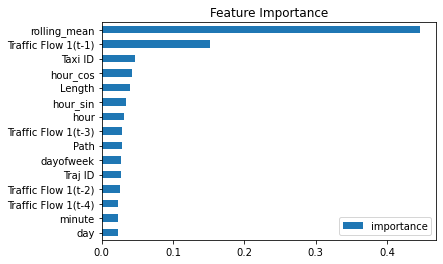

time: 422 ms (started: 2023-06-30 18:18:13 +03:00)


In [31]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Make predictions on the test set

In [32]:
y_pred = reg.predict(X_test)

time: 47 ms (started: 2023-06-30 18:18:16 +03:00)


### Plot Train and Validation errors

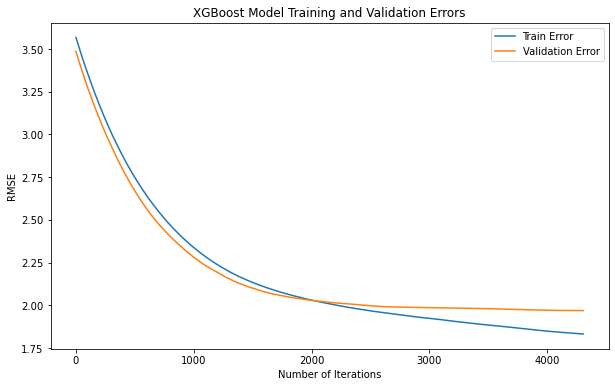

time: 297 ms (started: 2023-06-30 18:18:18 +03:00)


In [33]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error')
plt.plot(validation_errors, label='Validation Error')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

### Evaluate the results

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mae is: ",mean_absolute_error(y_test, y_pred))

# Calculate RMSE score
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE score:", rmse)

Mae is:  1.4555046464213066
RMSE score: 1.9687239658211784
time: 16 ms (started: 2023-06-30 18:18:21 +03:00)


In [ ]:
y_pred_train = reg.predict(X_train)
y_train['Predicted'] = y_pred_train
y_train['Path'] = X_train['Path']

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(y_train[y_train['Path']==0][['Traffic Flow 1(t)','Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.show()

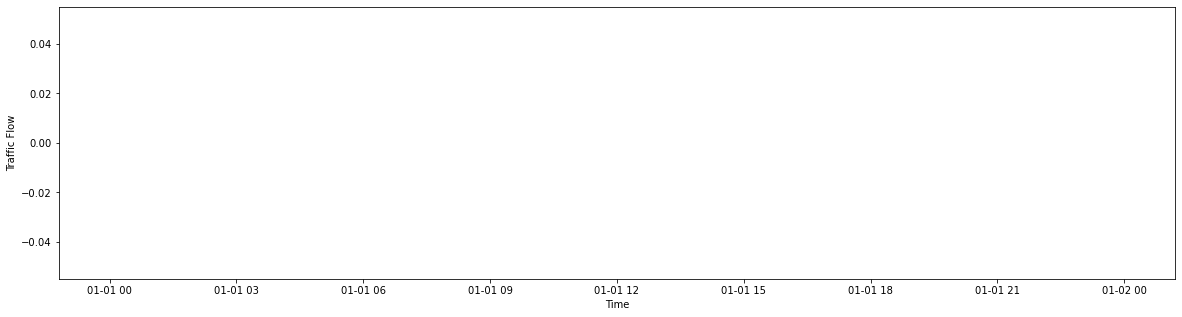

time: 266 ms (started: 2023-06-30 18:19:03 +03:00)


In [38]:
y_test['Predicted'] = y_pred
y_test['Path'] = X_test['Path']

# plot an example of the train-predictions
plt.figure(figsize=(20,5))
plt.plot(y_test[y_test['Path']==32][['Traffic Flow 1(t)','Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.show()